In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
from tqdm.auto import tqdm

from model import build_model
from datasets import get_datasets, get_data_loaders
from utils import save_model, save_plots
import glob
import numpy as np
import os
import shutil

/home/a4000/anaconda3/envs/quang-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

data_dir = '/home/os/Desktop/SETA/Seta_Car/TextRecognition/dataset_carmodels/raw_data'
train_dir = '/home/os/Desktop/SETA/Seta_Car/TextRecognition/dataset_carmodels/train_data'
for c in os.listdir(data_dir):
    print(c)
    os.mkdir(os.path.join(train_dir, c))
    count = 0
    for img in os.listdir(os.path.join(data_dir,c)):
        img_dst = os.path.join(train_dir,c)+'/'+c+str(count)+'.png'
        shutil.copyfile(os.path.join(data_dir,c,img), img_dst)
        count=count+1


In [8]:
data_dir = '/home/a4000/Data/nhungnth/car_logo_classify/Dataset'
TRAIN_RATIO = 0.9

train_dir = '/home/a4000/Data/nhungnth/car_logo_classify/train'
test_dir = '/home/a4000/Data/nhungnth/car_logo_classify/test'

# if os.path.exists(train_dir):
#     shutil.rmtree(train_dir) 
# if os.path.exists(test_dir):
#     shutil.rmtree(test_dir)
    
# os.makedirs(train_dir)
# os.makedirs(test_dir)

# classes = os.listdir(data_dir)
# print(classes)
# for c in classes:
    
#     class_dir = os.path.join(data_dir, c)
    
#     images = os.listdir(class_dir)
       
#     n_train = int(len(images) * TRAIN_RATIO)
    
#     train_images = images[:n_train]
#     test_images = images[n_train:]
    
#     os.makedirs(os.path.join(train_dir, c), exist_ok = True)
#     os.makedirs(os.path.join(test_dir, c), exist_ok = True)
#     count = 0
#     for image in train_images:
#         new_name = c+str(count)+'.png'
#         image_src = os.path.join(class_dir, image)
#         image_dst = os.path.join(train_dir, c, new_name)  
#         shutil.copyfile(image_src, image_dst)
#         count=count+1
#     count = 0    
#     for image in test_images:
#         new_name = c+str(count)+'.png'
#         image_src = os.path.join(class_dir, image)
#         image_dst = os.path.join(test_dir, c, new_name) 
#         shutil.copyfile(image_src, image_dst)
#         count=count+1

In [9]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


In [10]:
dataset_train, dataset_valid, dataset_classes = get_datasets()

In [11]:
dataset_classes

['ford',
 'honda',
 'hyundai',
 'kia',
 'kia-new',
 'lexus',
 'mazda',
 'mercedes',
 'mitsubishi',
 'opel',
 'toyota',
 'volkswagen']

In [8]:
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in dataset_train:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(dataset_train)
stds /= len(dataset_train)
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([-0.6478, -0.5531, -0.2821])
Calculated stds: tensor([1.2604, 1.2846, 1.2955])


In [3]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

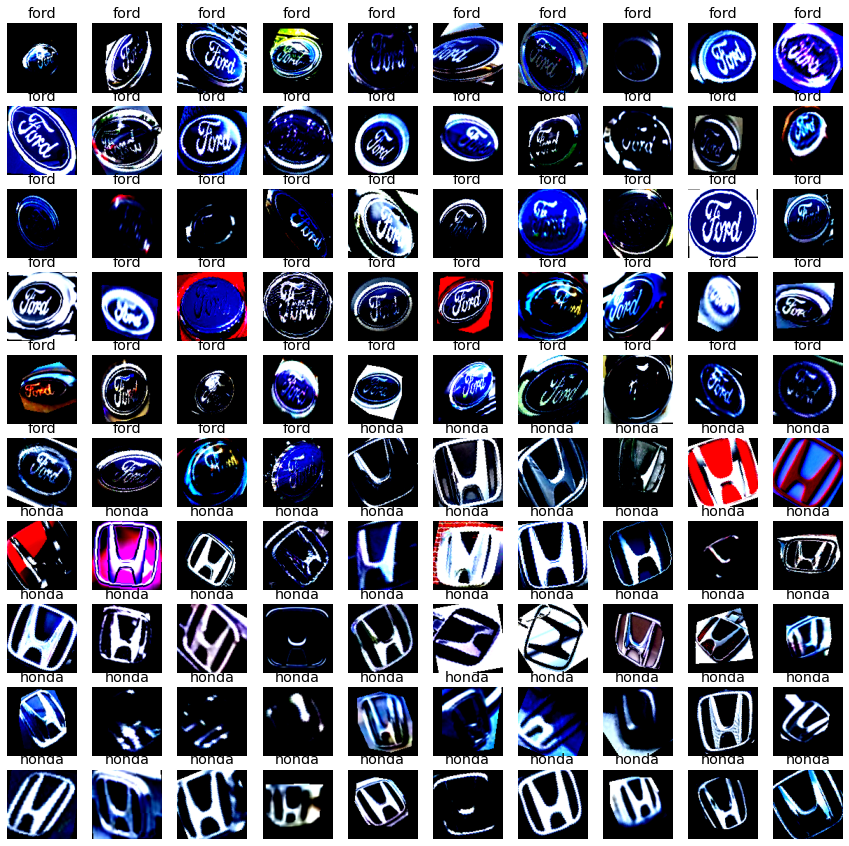

In [17]:
N_IMAGES = 100

images, labels = zip(*[(image, label) for image, label in 
                           [dataset_train[i] for i in range(N_IMAGES)]])

classes = dataset_valid.classes

plot_images(images, labels, classes)

In [18]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

VALID_RATIO = 0.8

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


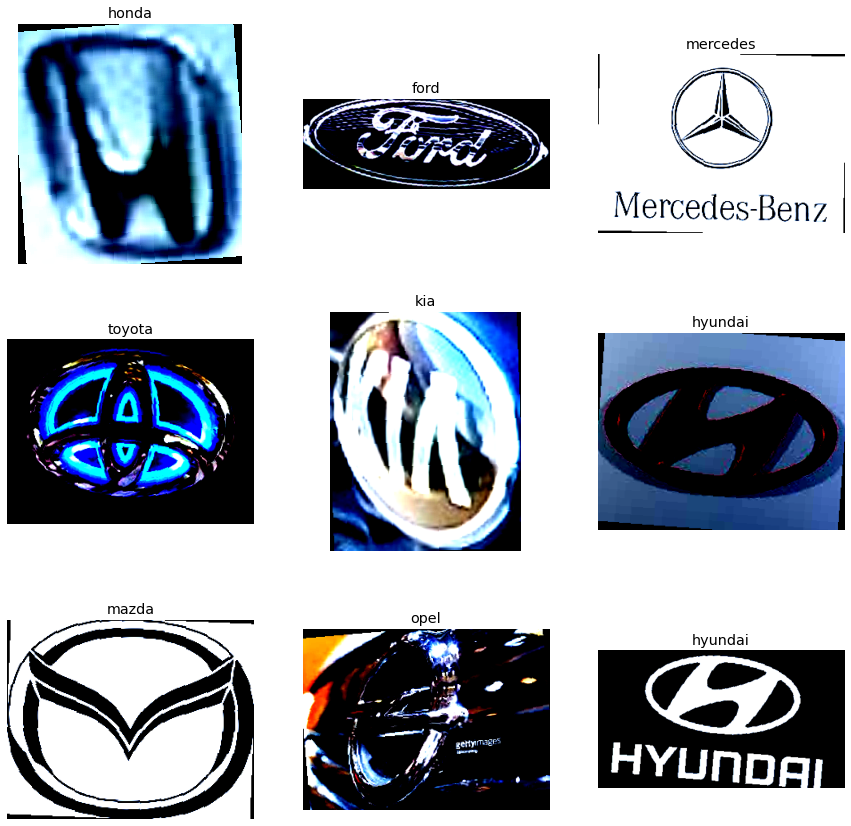

In [14]:
N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)